In [1]:
import pandas as pd
import geopandas as gpd
import censusdata
import matplotlib.pyplot as plt
import numpy as np
import plotly.figure_factory as ff

import warnings
from shapely.errors import ShapelyDeprecationWarning
warnings.filterwarnings("ignore", category=ShapelyDeprecationWarning)

The purpose of this file is to compile my practice/exploration of different APIs that access census.gov data. 
At the same time, I am running exploratory data analysis on my home state of Illinois and letting curiosity lead me.

Available surveys results accessible by censusdata:
ACS 5-year estimates (2005-2009 to 2015-2019),
ACS 1-year estimates (2012-2019),
ACS 3-year estimates (2010-2012 to 2011-2013),
ACS 1-year supplemental estimates (2014-2019),
Census 2010 Summary File 1.
Additionally, cenpy is able to access the census bureau's decennial census.

Tables can be accessed at the census.gov website via https://data.census.gov/table 

The search function in censusdata gives a large list of data that can take a while to sort through. 
For the purposes of streamlining the search process, I use the following function. I will mostly be using this in conjunction with the censusdata search function and the cenpy built in table-filter function.

In [2]:
# Meant to be used specifically in conjunction with censusdata searches
# Meant to narrow down the list of tables with input of specifying terms
# This should output a narrower list of data

# Example use case: searchSample(sample, ['white', 'sex', 'work', 'earnings'])

def searchSample(sampleData, searchTerms):
    newTableList = []
    # Base case when number of searchTerms equals 0
    # Remove last term of list to get rid of extraneous part
    # Return final narrowed down list of tables
    if (len(searchTerms) == 0):
        assert len(
            sampleData) != 0, "Data list is empty, try different search terms"
        sampleData.pop()
        return sampleData
    searchTerm = searchTerms[len(searchTerms) - 1].upper()
    # Index through sampleData, adding to a new list of tables
    # Will continue recursively until searchTerms are depleted
    for index, element in enumerate(sampleData):
        tablecode, tabledesc, tabledata = element
        if searchTerm in tabledesc:
            newTableList.append(element)
        elif searchTerm in tablecode:
            newTableList.append(element)
        for part in tabledata.upper().split("!!"):
            if searchTerm in part:
                newTableList.append(element)
    # Recursive call that makes the problem smaller by decreasing the number of searchterms
    # And also searching through only the new list
    searchTerms.remove(searchTerms[len(searchTerms) - 1])
    return searchSample(newTableList, searchTerms)

# Individuals Employed While Enrolled in School

Here I am searching for the concept education under the 2017 ACS5 survey.
This would normally output a list of hundreds of entries, but I narrow it down with the terms "employment", "enrollment", and "employed" into the 12 most relevant tables.

In [3]:
sample = censusdata.search('acs5', 2017, 'concept', 'education')
searchSample(sample, ['employment', 'employed', 'enrollment'])

[('B14005_004E',
  'SEX BY SCHOOL ENROLLMENT BY EDUCATIONAL ATTAINMENT BY EMPLOYMENT STATUS FOR THE POPULATION 16 TO 19 YEARS',
  'Estimate!!Total!!Male!!Enrolled in school!!Employed'),
 ('B14005_005E',
  'SEX BY SCHOOL ENROLLMENT BY EDUCATIONAL ATTAINMENT BY EMPLOYMENT STATUS FOR THE POPULATION 16 TO 19 YEARS',
  'Estimate!!Total!!Male!!Enrolled in school!!Unemployed'),
 ('B14005_009E',
  'SEX BY SCHOOL ENROLLMENT BY EDUCATIONAL ATTAINMENT BY EMPLOYMENT STATUS FOR THE POPULATION 16 TO 19 YEARS',
  'Estimate!!Total!!Male!!Not enrolled in school!!High school graduate (includes equivalency)!!Employed'),
 ('B14005_010E',
  'SEX BY SCHOOL ENROLLMENT BY EDUCATIONAL ATTAINMENT BY EMPLOYMENT STATUS FOR THE POPULATION 16 TO 19 YEARS',
  'Estimate!!Total!!Male!!Not enrolled in school!!High school graduate (includes equivalency)!!Unemployed'),
 ('B14005_013E',
  'SEX BY SCHOOL ENROLLMENT BY EDUCATIONAL ATTAINMENT BY EMPLOYMENT STATUS FOR THE POPULATION 16 TO 19 YEARS',
  'Estimate!!Total!!Male!!

We can download from censusdata to get a pandas dataframe with our specifications. 
Visualization of the data can be accomplished with figure factory from plotly.
It is necessary to tinker with the dataframe so that we can visualize it using figure_factory

In [4]:
df = censusdata.download('acs5', 2017, censusdata.censusgeo(
    [('state', '17'), ('county', '*')]), ['B14005_004E', 'B14005_018E'])

column_names = ['Male_Employed_Enrolled', 'Female_Employed_Enrolled']
df.columns = column_names
df['Total_Employed_Enrolled'] = df['Male_Employed_Enrolled'] + df['Female_Employed_Enrolled']

FIPS_codes = []
county_names = []
for index in df.index.tolist():
    FIPScode = index.geo[0][1] + index.geo[1][1]
    FIPS_codes.append(FIPScode)
    countyname = index.name.split(',')[0]
    county_names.append(countyname)
df.index = FIPS_codes
df['County'] = county_names

df


,Male_Employed_Enrolled,Female_Employed_Enrolled,Total_Employed_Enrolled,County
17067,64,36,100,Hancock County
17119,1696,2320,4016,Madison County
17063,294,551,845,Grundy County
17091,779,965,1744,Kankakee County
17131,65,204,269,Mercer County
...,...,...,...,...
17171,19,37,56,Scott County
17179,1141,920,2061,Tazewell County
17017,61,90,151,Cass County
17187,202,275,477,Warren County


Here, I create a choropleth with the values of total people concurrently enrolled in school while being employed.
We can see, however, that the visualization seems the be classifying the data based on "levels", where a county with a whopping 42,000 number of employed enrolled is treated visually the same as a county that has only 5326 employed enrolled. This can be misleading!  

(For future reference) 
https://plotly.com/python/choropleth-maps/ 

In [5]:
fig = ff.create_choropleth(fips=df.index, scope=['Illinois'], values=df.Total_Employed_Enrolled,
                           title='Total employed while enrolled in school in Illinois', legend_title='# Employed Enrolled')
fig.layout.template = None
fig.show()


Additionally, the cenpy library gives us many different ways of visualizing data under its "products" functions. 

(For future reference) 
https://cenpy-devs.github.io/cenpy/api.html

In [6]:
from cenpy import products

In [7]:
# With the from_state function, making the level into tract may lead into a malformed API call
# I will set the level into county instead
il, il_bounds = products.ACS(2017).from_state('Illinois', level='county', variables=['B14005_004E', 'B14005_018E'], strict_within=True, return_bounds=True)

c:\Users\jrh25\anaconda3\lib\site-packages\cenpy\products.py:767: FutureWarning:

The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.



In [8]:
# Creating a new column "Total" representing the total (male + female) population concurrently employed while enrolled in school
il['Total'] = il['B14005_004E'] + il['B14005_018E']
il.sort_values('Total', ascending=False)

,GEOID,geometry,B14005_004E,B14005_018E,NAME,state,county,Total
20,17031,"POLYGON ((-9743238.100 5107895.390, -9743244.0...",20972.0,24159.0,"Cook County, Illinois",17,031,45131.0
19,17043,"POLYGON ((-9787228.670 5154714.820, -9787228.7...",6118.0,7355.0,"DuPage County, Illinois",17,043,13473.0
66,17197,"POLYGON ((-9743374.020 5069339.040, -9743374.5...",5602.0,6224.0,"Will County, Illinois",17,197,11826.0
67,17097,"POLYGON ((-9784759.600 5235252.660, -9784723.6...",5459.0,5402.0,"Lake County, Illinois",17,097,10861.0
50,17089,"POLYGON ((-9837895.620 5119517.910, -9837947.2...",4767.0,5128.0,"Kane County, Illinois",17,089,9895.0
...,...,...,...,...,...,...,...,...
16,17059,"POLYGON ((-9800574.430 4547824.220, -9800582.3...",13.0,19.0,"Gallatin County, Illinois",17,059,32.0
72,17009,"POLYGON ((-10078504.350 4855261.390, -10078500...",0.0,26.0,"Brown County, Illinois",17,009,26.0
63,17069,"POLYGON ((-9820760.880 4503146.680, -9820792.6...",11.0,10.0,"Hardin County, Illinois",17,069,21.0
80,17003,"POLYGON ((-9965151.280 4479230.540, -9965147.7...",10.0,9.0,"Alexander County, Illinois",17,003,19.0


Using cenpy to create a data visualization with the same data as my previous figure_factory choropleth:

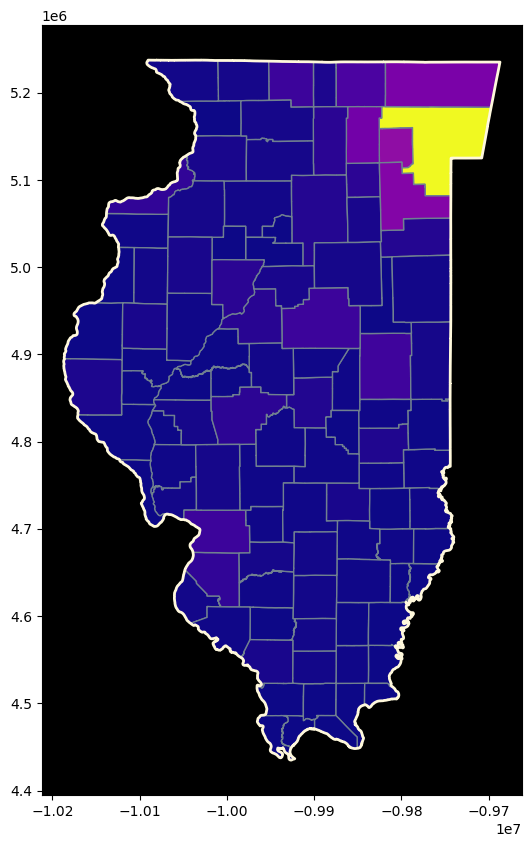

In [9]:
f, ax = plt.subplots(1,1,figsize=(10,10))
il.dropna(subset=['Total'], axis=0).plot('Total', ax=ax, cmap='plasma', edgecolor='slategrey')
il_bounds.plot(edgecolor='cornsilk', color='none', ax=ax, linewidth=2)
ax.set_facecolor('k')

The choropleth made in figure_factory appears to be better suited towards visualizing data based on "levels" whereas the cenpy visualization visualizes based on "magnitude", which is why the areas for Cook, Dupage, Will, Lake, and Kane county are brighter than other counties in the cenpy visualization. Not surprisingly, Cook County (which contains the city of Chicago) has the largest number of people employed while enrolled in school. This is much better at identifying outliers in the data, but doesn't account for population density in each area. 

One way to fix this would be to base our visualization on the proportion of the population in each county instead of sheer numbers. 

In [10]:
il, il_bounds = products.ACS(2017).from_state('Illinois', level='county', variables=['B14005_004E', 'B14005_018E', 'B01003_001E'], strict_within=True, return_bounds=True)

c:\Users\jrh25\anaconda3\lib\site-packages\cenpy\products.py:767: FutureWarning:

The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.



In [11]:
# Creating a new column "Total" representing the total (male + female) population concurrently employed while enrolled in school
il['Total'] = il['B14005_004E'] + il['B14005_018E']
# Creating a new column "Percent" representating the proportion of county population concurrently employed while enrolled in school
il['Percent'] = il['Total'] / il['B01003_001E']
il.sort_values('Percent', ascending=False)

,GEOID,geometry,B01003_001E,B14005_004E,B14005_018E,NAME,state,county,Total,Percent
24,17187,"POLYGON ((-10106300.050 5013888.620, -10106299...",17429.0,202.0,275.0,"Warren County, Illinois",17,187,477.0,0.027368
73,17109,"POLYGON ((-10093694.230 4958138.710, -10093678...",31597.0,438.0,409.0,"McDonough County, Illinois",17,109,847.0,0.026806
41,17049,"POLYGON ((-9885782.370 4746506.410, -9885780.3...",34164.0,412.0,455.0,"Effingham County, Illinois",17,049,867.0,0.025378
33,17035,"POLYGON ((-9820998.440 4746250.250, -9821637.7...",10899.0,140.0,132.0,"Cumberland County, Illinois",17,035,272.0,0.024956
34,17029,"POLYGON ((-9792119.820 4805608.170, -9792114.2...",52540.0,544.0,729.0,"Coles County, Illinois",17,029,1273.0,0.024229
...,...,...,...,...,...,...,...,...,...,...
55,17067,"POLYGON ((-10119619.310 4946317.490, -10119620...",18264.0,64.0,36.0,"Hancock County, Illinois",17,067,100.0,0.005475
63,17069,"POLYGON ((-9820760.880 4503146.680, -9820792.6...",4161.0,11.0,10.0,"Hardin County, Illinois",17,069,21.0,0.005047
72,17009,"POLYGON ((-10078504.350 4855261.390, -10078500...",6791.0,0.0,26.0,"Brown County, Illinois",17,009,26.0,0.003829
80,17003,"POLYGON ((-9965151.280 4479230.540, -9965147.7...",6776.0,10.0,9.0,"Alexander County, Illinois",17,003,19.0,0.002804


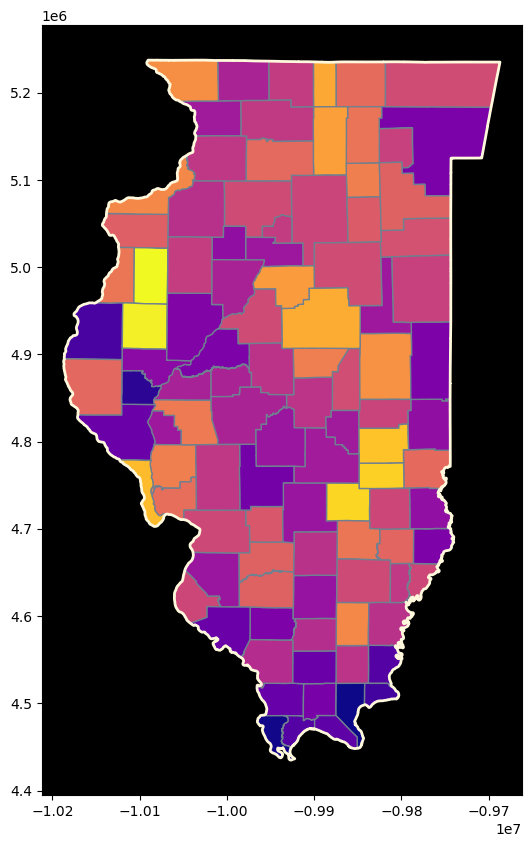

In [12]:
f, ax = plt.subplots(1,1,figsize=(10,10))
il.dropna(subset=['Percent'], axis=0).plot('Percent', ax=ax, cmap='plasma', edgecolor='slategrey')
il_bounds.plot(edgecolor='cornsilk', color='none', ax=ax, linewidth=2)
ax.set_facecolor('k')

This is already a much more interesting visualization than the previous! If we look at our dataframe now then we can see that the Warren, McDonough, and Effingham counties have the some of the highest proportiosn of people employed while enrolled in school. 

Let's see if we can explore other statistics, such as race, income, occupations, education, etc. Starting with race, we can perform a quick search using a combination of the cenpy built in function to filter tables and see ones that are relevant to us.

# Analyzing Race Distribution

In [13]:
products.ACS().filter_tables('RACE', by='description')

,description,columns
table_name,,
B02001,RACE,"[B02001_001E, B02001_002E, B02001_003E, B02001..."
B02008,WHITE ALONE OR IN COMBINATION WITH ONE OR MORE...,[B02008_001E]
B02009,BLACK OR AFRICAN AMERICAN ALONE OR IN COMBINAT...,[B02009_001E]
B02010,AMERICAN INDIAN AND ALASKA NATIVE ALONE OR IN ...,[B02010_001E]
B02011,ASIAN ALONE OR IN COMBINATION WITH ONE OR MORE...,[B02011_001E]
B02012,NATIVE HAWAIIAN AND OTHER PACIFIC ISLANDER ALO...,[B02012_001E]
B02013,SOME OTHER RACE ALONE OR IN COMBINATION WITH O...,[B02013_001E]
B03002,HISPANIC OR LATINO ORIGIN BY RACE,"[B03002_001E, B03002_002E, B03002_003E, B03002..."
B25006,RACE OF HOUSEHOLDER,"[B25006_001E, B25006_002E, B25006_003E, B25006..."


In [14]:
sample = censusdata.search('acs5', 2017, 'concept', 'race')
searchSample(sample, ['B02001'])

[('B02001_001E', 'RACE', 'Estimate!!Total'),
 ('B02001_002E', 'RACE', 'Estimate!!Total!!White alone'),
 ('B02001_003E', 'RACE', 'Estimate!!Total!!Black or African American alone'),
 ('B02001_004E',
  'RACE',
  'Estimate!!Total!!American Indian and Alaska Native alone'),
 ('B02001_005E', 'RACE', 'Estimate!!Total!!Asian alone'),
 ('B02001_006E',
  'RACE',
  'Estimate!!Total!!Native Hawaiian and Other Pacific Islander alone'),
 ('B02001_007E', 'RACE', 'Estimate!!Total!!Some other race alone'),
 ('B02001_008E', 'RACE', 'Estimate!!Total!!Two or more races'),
 ('B02001_009E',
  'RACE',
  'Estimate!!Total!!Two or more races!!Two races including Some other race')]

In [15]:
il, il_bounds = products.ACS(2017).from_state('Illinois', level='county', variables=['B02001_002E', 'B02001_003E', 'B02001_004E', 'B02001_005E', 'B02001_006E', 'B01003_001E'], strict_within=True, return_bounds=True)

c:\Users\jrh25\anaconda3\lib\site-packages\cenpy\products.py:767: FutureWarning:

The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.



In [16]:
il['%_White'] = il['B02001_002E'] / il['B01003_001E']
il['%_Black'] = il['B02001_003E'] / il['B01003_001E']
il['%_American_Indian'] = il['B02001_004E'] / il['B01003_001E']
il['%_Asian'] = il['B02001_005E'] / il['B01003_001E']
il['%_Pacific_Islander'] = il['B02001_006E'] / il['B01003_001E']

In [17]:
il.sort_values('%_White', ascending=False).head(5)

,GEOID,geometry,B01003_001E,B02001_002E,B02001_003E,B02001_004E,B02001_005E,B02001_006E,NAME,state,county,%_White,%_Black,%_American_Indian,%_Asian,%_Pacific_Islander
46,17065,"POLYGON ((-9837543.290 4597113.210, -9837543.4...",8259.0,8193.0,49.0,7.0,10.0,0.0,"Hamilton County, Illinois",17,065,0.992009,0.005933,0.000848,0.001211,0.00000
47,17079,"POLYGON ((-9801943.880 4700130.610, -9802054.5...",9608.0,9470.0,38.0,6.0,1.0,0.0,"Jasper County, Illinois",17,079,0.985637,0.003955,0.000624,0.000104,0.00000
100,17173,"POLYGON ((-9910293.370 4815815.620, -9910119.1...",21906.0,21540.0,151.0,43.0,81.0,0.0,"Shelby County, Illinois",17,173,0.983292,0.006893,0.001963,0.003698,0.00000
1,17171,"POLYGON ((-10060272.890 4817492.690, -10058948...",5109.0,5019.0,6.0,25.0,4.0,7.0,"Scott County, Illinois",17,171,0.982384,0.001174,0.004893,0.000783,0.00137
29,17139,"POLYGON ((-9886585.540 4828301.770, -9886427.9...",14711.0,14430.0,85.0,30.0,30.0,0.0,"Moultrie County, Illinois",17,139,0.980899,0.005778,0.002039,0.002039,0.00000


Visualizing percentage of Whites in each county:

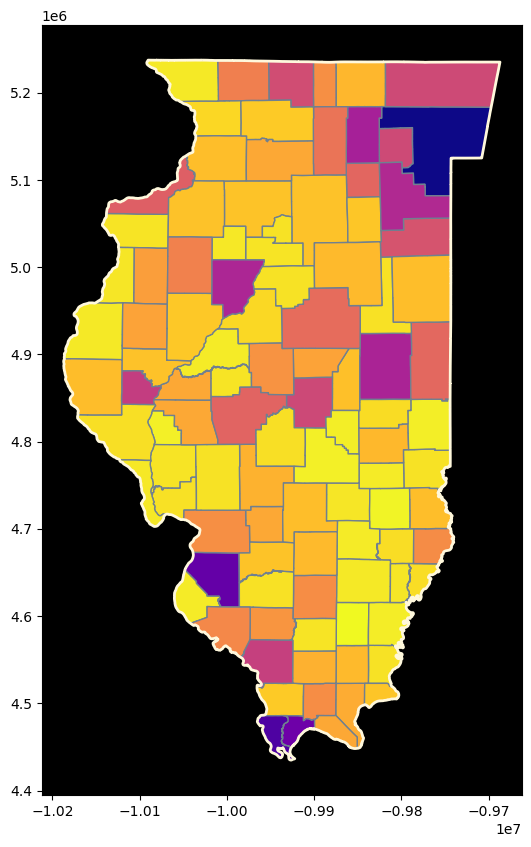

In [18]:
f, ax = plt.subplots(1,1,figsize=(10,10))
il.dropna(subset=['%_White'], axis=0).plot('%_White', ax=ax, cmap='plasma', edgecolor='slategrey')
il_bounds.plot(edgecolor='cornsilk', color='none', ax=ax, linewidth=2)
ax.set_facecolor('k')

Visualizing percentage of Black/African Americans in each county:

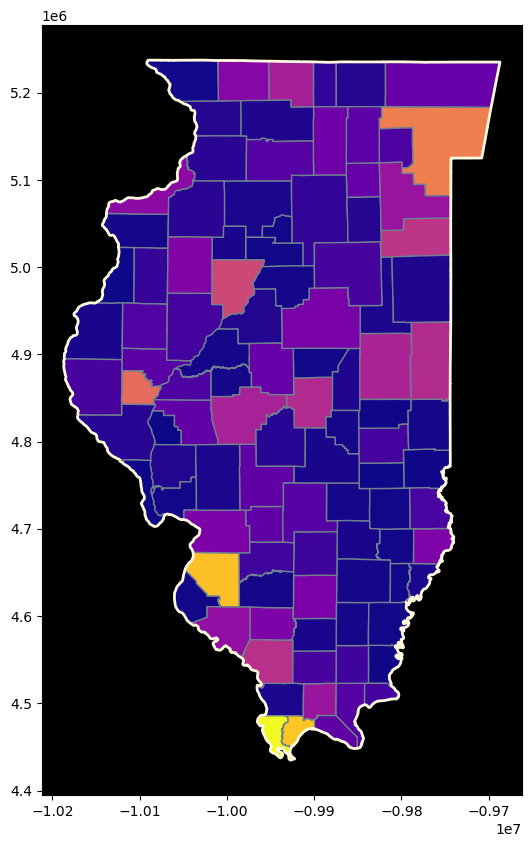

In [19]:
f, ax = plt.subplots(1,1,figsize=(10,10))
il.dropna(subset=['%_Black'], axis=0).plot('%_Black', ax=ax, cmap='plasma', edgecolor='slategrey')
il_bounds.plot(edgecolor='cornsilk', color='none', ax=ax, linewidth=2)
ax.set_facecolor('k')

Visualizing percentage of American Indians in each county:

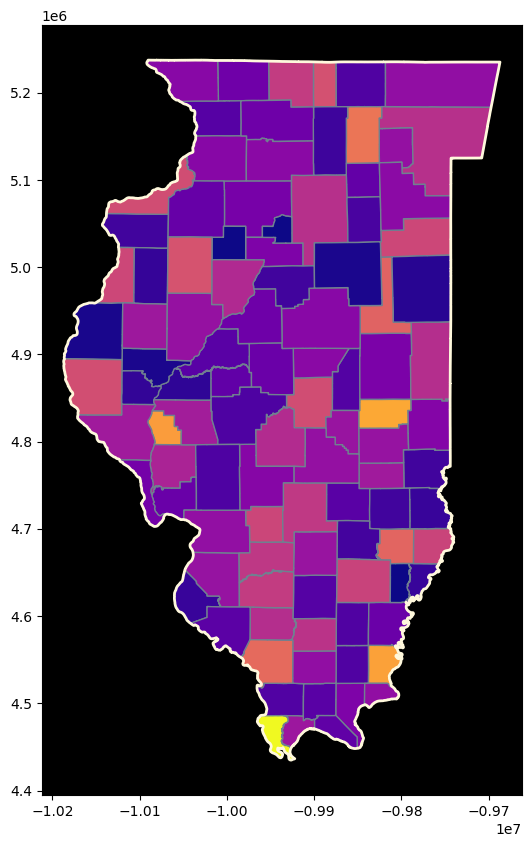

In [20]:
f, ax = plt.subplots(1,1,figsize=(10,10))
il.dropna(subset=['%_American_Indian'], axis=0).plot('%_American_Indian', ax=ax, cmap='plasma', edgecolor='slategrey')
il_bounds.plot(edgecolor='cornsilk', color='none', ax=ax, linewidth=2)
ax.set_facecolor('k')

Visualizing percentage of Asians in each county:

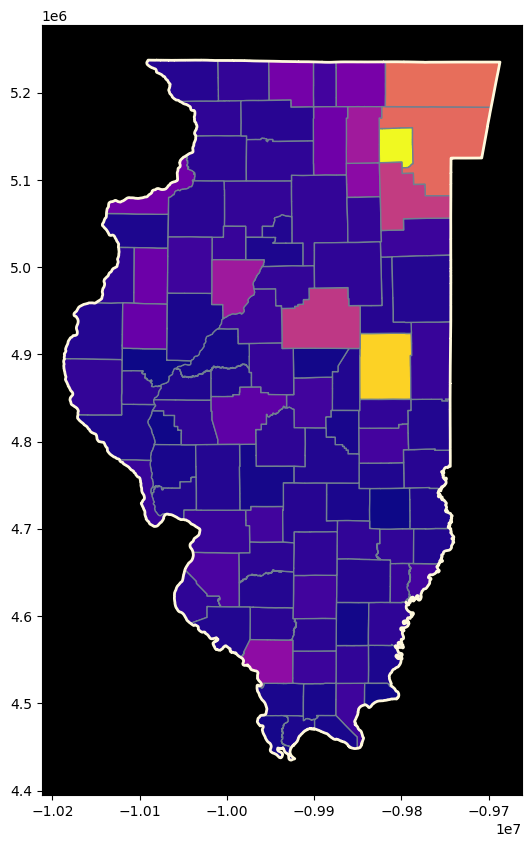

In [21]:
f, ax = plt.subplots(1,1,figsize=(10,10))
il.dropna(subset=['%_Asian'], axis=0).plot('%_Asian', ax=ax, cmap='plasma', edgecolor='slategrey')
il_bounds.plot(edgecolor='cornsilk', color='none', ax=ax, linewidth=2)
ax.set_facecolor('k')

In [22]:
il.sort_values('%_Asian', ascending=False).head(2)

,GEOID,geometry,B01003_001E,B02001_002E,B02001_003E,B02001_004E,B02001_005E,B02001_006E,NAME,state,county,%_White,%_Black,%_American_Indian,%_Asian,%_Pacific_Islander
19,17043,"POLYGON ((-9787228.670 5154714.820, -9787228.7...",931826.0,729495.0,43525.0,1827.0,105771.0,280.0,"DuPage County, Illinois",17,043,0.782866,0.046709,0.001961,0.113509,0.000300
7,17019,"POLYGON ((-9788321.930 4911586.270, -9788319.3...",207946.0,151258.0,27210.0,323.0,21481.0,128.0,"Champaign County, Illinois",17,019,0.727391,0.130851,0.001553,0.103301,0.000616


The highest proportion of Asians in Illinois are in Dupage and Champaign county.

Visualizing percentage of Pacific Islanders in each county:

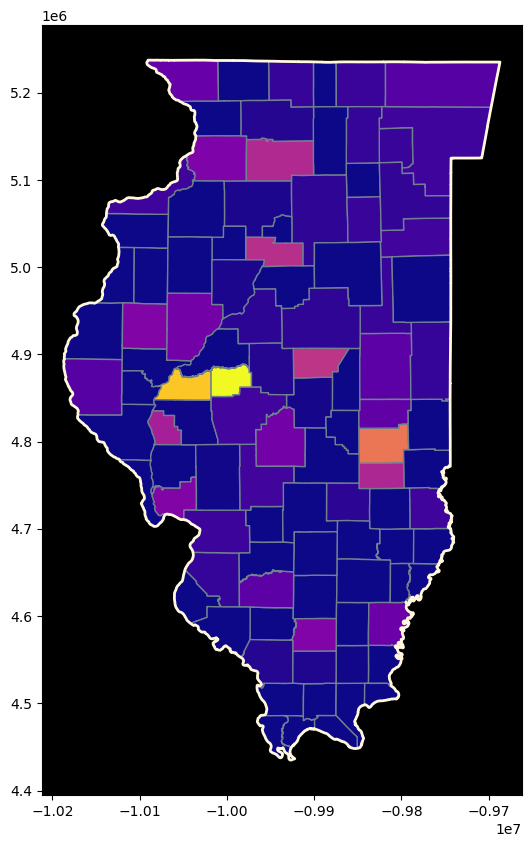

In [23]:
f, ax = plt.subplots(1,1,figsize=(10,10))
il.dropna(subset=['%_Pacific_Islander'], axis=0).plot('%_Pacific_Islander', ax=ax, cmap='plasma', edgecolor='slategrey')
il_bounds.plot(edgecolor='cornsilk', color='none', ax=ax, linewidth=2)
ax.set_facecolor('k')

Here, the visualization seems to be exaggerating the differences in Pacific Islander populations between counties. The counties with the most significant Pacific Islander populations as shown above only have 0.3% higher proportion of that demographic than most other counties.

In [24]:
il.sort_values('%_Pacific_Islander', ascending=False).head(2)

,GEOID,geometry,B01003_001E,B02001_002E,B02001_003E,B02001_004E,B02001_005E,B02001_006E,NAME,state,county,%_White,%_Black,%_American_Indian,%_Asian,%_Pacific_Islander
25,17129,"POLYGON ((-9981903.190 4889316.930, -9981837.7...",12416.0,12057.0,63.0,14.0,43.0,47.0,"Menard County, Illinois",17,129,0.971086,0.005074,0.001128,0.003463,0.003785
12,17017,"POLYGON ((-10018195.790 4872723.500, -10018202...",12880.0,11692.0,596.0,5.0,41.0,43.0,"Cass County, Illinois",17,017,0.907764,0.046273,0.000388,0.003183,0.003339


# Average Earnings per Household

Next, I'll take a look at the statistics for household earnings in Illinois from the ACS 2019 survey. I begin with processing the relevant tables into a dataframe.

In [25]:
sample = censusdata.search('acs5', 2019, 'concept', 'earnings')
searchSample(sample, ['earnings', 'household'])

[('B19051_001E',
  'EARNINGS IN THE PAST 12 MONTHS FOR HOUSEHOLDS',
  'Estimate!!Total:'),
 ('B19051_002E',
  'EARNINGS IN THE PAST 12 MONTHS FOR HOUSEHOLDS',
  'Estimate!!Total:!!With earnings'),
 ('B19051_002E',
  'EARNINGS IN THE PAST 12 MONTHS FOR HOUSEHOLDS',
  'Estimate!!Total:!!With earnings'),
 ('B19051_003E',
  'EARNINGS IN THE PAST 12 MONTHS FOR HOUSEHOLDS',
  'Estimate!!Total:!!No earnings'),
 ('B19051_003E',
  'EARNINGS IN THE PAST 12 MONTHS FOR HOUSEHOLDS',
  'Estimate!!Total:!!No earnings'),
 ('B19061_001E',
  'AGGREGATE EARNINGS IN THE PAST 12 MONTHS (IN 2019 INFLATION-ADJUSTED DOLLARS) FOR HOUSEHOLDS',
  'Estimate!!Aggregate earnings in the past 12 months (in 2019 inflation-adjusted dollars)'),
 ('B19061_001E',
  'AGGREGATE EARNINGS IN THE PAST 12 MONTHS (IN 2019 INFLATION-ADJUSTED DOLLARS) FOR HOUSEHOLDS',
  'Estimate!!Aggregate earnings in the past 12 months (in 2019 inflation-adjusted dollars)'),
 ('B26117_022E',
  'GROUP QUARTERS TYPE (3 TYPES) BY SEX WITH EARNINGS 

In [26]:
df_earnings = censusdata.download('acs5', 2019, censusdata.censusgeo(
    [('state', '17'), ('county', '*')]), ['B19051_001E', 'B19051_002E', 'B19051_003E', 'B19061_001E'])
column_names = ['Total', 'Total_With_Earnings', 'Total_No_Earnings', 'Aggregate_Earnings']
df_earnings.columns = column_names
FIPS_codes = []
county_names = []
for index in df_earnings.index.tolist():
    FIPScode = index.geo[0][1] + index.geo[1][1]
    FIPS_codes.append(FIPScode)
    countyname = index.name.split(',')[0]
    county_names.append(countyname)
df_earnings.index = FIPS_codes
df_earnings['County'] = county_names
df_earnings['%_With_Earnings'] = df_earnings.Total_With_Earnings / df_earnings.Total
df_earnings['%_No_Earnings'] = df_earnings.Total_No_Earnings / df_earnings.Total
df_earnings['Avg_Household_Earnings'] = df_earnings.Aggregate_Earnings / df_earnings.Total_With_Earnings

df_earnings.sort_values('Avg_Household_Earnings', ascending=False).head(4)


,Total,Total_With_Earnings,Total_No_Earnings,Aggregate_Earnings,County,%_With_Earnings,%_No_Earnings,Avg_Household_Earnings
17097,246122,203850,42272,25785051300,Lake County,0.828248,0.171752,126490.317881
17043,342791,284657,58134,35195759400,DuPage County,0.830410,0.169590,123642.697703
17093,40721,35768,4953,3913036600,Kendall County,0.878367,0.121633,109400.486468
17197,229498,190621,38877,20441816500,Will County,0.830600,0.169400,107238.008929


In [27]:
df_earnings.describe()

,Total,Total_With_Earnings,Total_No_Earnings,Aggregate_Earnings,%_With_Earnings,%_No_Earnings,Avg_Household_Earnings
count,1.020000e+02,1.020000e+02,102.000000,1.020000e+02,102.000000,102.000000,102.000000
mean,4.751112e+04,3.721393e+04,10297.186275,3.544324e+09,0.726911,0.273089,72576.287372
std,1.995243e+05,1.585966e+05,41008.106111,1.612814e+10,0.057347,0.057347,13859.859246
min,1.363000e+03,8.220000e+02,525.000000,4.303810e+07,0.485242,0.121633,50145.194599
25%,5.963500e+03,4.287250e+03,1589.000000,2.796568e+08,0.700892,0.243024,63840.293141
50%,1.038450e+04,7.603500e+03,2887.500000,4.735846e+08,0.730080,0.269920,69346.547925
75%,2.099725e+04,1.589200e+04,5642.750000,1.205213e+09,0.756976,0.299108,76653.063873
max,1.972108e+06,1.563020e+06,409088.000000,1.568511e+11,0.878367,0.514758,126490.317881


I then construct a choropleth for average household earnings. We can see that the counties with the highest average household earnings lie in the northeast corner of Illinois, where Lake, Kendall, Cook and Dupage county are. The distribution of colors in the choropleth for average household earnings appears similar to our first choropleth on enrolled/employed individuals, although there may not be a direct relationship between the two variables.

In [28]:
fig_earnings = ff.create_choropleth(fips=df_earnings.index, scope=['Illinois'], values=df_earnings.Avg_Household_Earnings,
                           title='Average Household Earnings 2019', legend_title='Avg Earnings')
fig_earnings.layout.template = None
fig_earnings.show()


Now I'm wondering how household incomes have changed since 2009. Comparing the two datasets can give us interesting information on what changed in the decade between the two surveys.

In [29]:
df_earnings1 = censusdata.download('acs5', 2009, censusdata.censusgeo(
    [('state', '17'), ('county', '*')]), ['B19051_001E', 'B19051_002E', 'B19051_003E', 'B19061_001E'])
column_names = ['Total', 'Total_With_Earnings', 'Total_No_Earnings', 'Aggregate_Earnings']
df_earnings1.columns = column_names
FIPS_codes = []
county_names = []
for index in df_earnings1.index.tolist():
    FIPScode = index.geo[0][1] + index.geo[1][1]
    FIPS_codes.append(FIPScode)
    countyname = index.name.split(',')[0]
    county_names.append(countyname)
df_earnings1.index = FIPS_codes
df_earnings1['County'] = county_names
df_earnings1['%_With_Earnings'] = df_earnings1.Total_With_Earnings / df_earnings1.Total
df_earnings1['%_No_Earnings'] = df_earnings1.Total_No_Earnings / df_earnings1.Total
df_earnings1['Avg_Household_Earnings'] = df_earnings1.Aggregate_Earnings / df_earnings1.Total_With_Earnings

df_earnings1.sort_values('Avg_Household_Earnings', ascending=False).head(4)

,Total,Total_With_Earnings,Total_No_Earnings,Aggregate_Earnings,County,%_With_Earnings,%_No_Earnings,Avg_Household_Earnings
17097,234840,203772,31068,21777506800,Lake County,0.867706,0.132294,106871.929411
17043,337055,291956,45099,29331634300,DuPage County,0.866197,0.133803,100465.941101
17111,106951,93145,13806,8261216200,McHenry County,0.870913,0.129087,88691.998497
17093,30248,26987,3261,2360968100,Kendall County,0.892191,0.107809,87485.385556


In [30]:
df_earnings1.describe()

,Total,Total_With_Earnings,Total_No_Earnings,Aggregate_Earnings,%_With_Earnings,%_No_Earnings,Avg_Household_Earnings
count,1.020000e+02,1.020000e+02,102.000000,1.020000e+02,102.000000,102.000000,102.000000
mean,4.656263e+04,3.781274e+04,8749.892157,2.875040e+09,0.765178,0.234822,58241.410455
std,1.960600e+05,1.597936e+05,36416.811642,1.278236e+10,0.052946,0.052946,11499.944362
min,1.751000e+03,1.129000e+03,549.000000,5.131830e+07,0.609642,0.107809,42202.549697
25%,6.258250e+03,4.487500e+03,1423.500000,2.507667e+08,0.735974,0.205953,50835.579747
50%,1.115700e+04,8.293500e+03,2301.000000,4.507776e+08,0.761400,0.238600,56214.940751
75%,2.167600e+04,1.692525e+04,5027.750000,9.941938e+08,0.794047,0.264026,61369.370383
max,1.941417e+06,1.575995e+06,365422.000000,1.238454e+11,0.892191,0.390358,106871.929411


In [31]:
fig_earnings1 = ff.create_choropleth(fips=df_earnings1.index, scope=['Illinois'], values=df_earnings1.Avg_Household_Earnings,
                           title='Average Household Earnings 2009', legend_title='Avg Earnings')
fig_earnings1.layout.template = None
fig_earnings1.show()

Looking at the two visualizations at face value tells us that some parts of Illinois in 2019 may have lower average household earnings than in 2009 (notice the increase in darker colors at the northwest counties). However, taking a look at the dataframes for each of these surveys tells a different story. Average household earnings actually increased across the board. The first thing that comes to mind is inflation being the factor, although the census tells us that earnings estimates are adjusted for inflation. 

Either way, we want to more clearly see the change in average household earnings between 2009-2019. To do this, I concatenate the average household earnings columns from the above two dataframes into a new one and find the percent change from 2009 to 2019.

In [32]:
df2 = pd.concat([df_earnings['County'], df_earnings['Avg_Household_Earnings'], df_earnings1['Avg_Household_Earnings']], axis=1, keys=['County', 'Avg_Earnings1', 'Avg_Earnings2'])
df2['%_Change'] = (df2['Avg_Earnings1'] - df2['Avg_Earnings2']) / df2['Avg_Earnings2']
df2.sort_values('%_Change', ascending=False).head(4)

,County,Avg_Earnings1,Avg_Earnings2,%_Change
17069,Hardin County,80202.147971,49451.870748,0.621822
17059,Gallatin County,68481.162325,46067.357763,0.486544
17009,Brown County,75318.833780,51315.935484,0.467747
17029,Coles County,66668.035343,45734.349760,0.457723


In [33]:
fig2 = ff.create_choropleth(fips=df2.index, scope=['Illinois'], values=df2['%_Change'],
                           title='% Change in Avg Earnings 2009-2019', legend_title='% Change')
fig2.layout.template = None
fig2.show()

The choropleth above shows that counties in the southern half of Illinois experienced the most growth in average household earnings from 2009 to 2019, with one county even experiencing a whopping 62 percent increase in average household income. This is interesting, but could there be a reason behind this cluster of economic growth? Is this growth evenly distributed throughout each county's population or are a few very wealthy people contributing to this change? 

# Poverty Income Levels

Let's begin with a general analysis of poverty statistics that the ACS5 census gives us. This could give us an idea about whether or not a larger portion of people experienced economic growth. Below, I download tables for individuals (male/female) with incomes below and above the poverty line. I begin with a visualization of the percent of total population above poverty level per county in 2019, followed by a visualization of the change in this variable from 2009 to 2019. 

In [34]:
sample = censusdata.search('acs5', 2019, 'concept', 'poverty')
searchSample(sample, ['employed', 'individual'])

[('B17005_005E',
  'POVERTY STATUS IN THE PAST 12 MONTHS OF INDIVIDUALS BY SEX BY EMPLOYMENT STATUS',
  'Estimate!!Total:!!Income in the past 12 months below poverty level:!!Male:!!In labor force:!!Employed'),
 ('B17005_006E',
  'POVERTY STATUS IN THE PAST 12 MONTHS OF INDIVIDUALS BY SEX BY EMPLOYMENT STATUS',
  'Estimate!!Total:!!Income in the past 12 months below poverty level:!!Male:!!In labor force:!!Unemployed'),
 ('B17005_010E',
  'POVERTY STATUS IN THE PAST 12 MONTHS OF INDIVIDUALS BY SEX BY EMPLOYMENT STATUS',
  'Estimate!!Total:!!Income in the past 12 months below poverty level:!!Female:!!In labor force:!!Employed'),
 ('B17005_011E',
  'POVERTY STATUS IN THE PAST 12 MONTHS OF INDIVIDUALS BY SEX BY EMPLOYMENT STATUS',
  'Estimate!!Total:!!Income in the past 12 months below poverty level:!!Female:!!In labor force:!!Unemployed'),
 ('B17005_016E',
  'POVERTY STATUS IN THE PAST 12 MONTHS OF INDIVIDUALS BY SEX BY EMPLOYMENT STATUS',
  'Estimate!!Total:!!Income in the past 12 months 

In [35]:
df_poverty2019 = censusdata.download('acs5', 2019, censusdata.censusgeo(
    [('state', '17'), ('county', '*')]), ['B17005_005E', 'B17005_006E', 'B17005_010E', 'B17005_011E',
                                          'B17005_016E', 'B17005_017E', 'B17005_021E', 'B17005_022E', 'B01003_001E'])
# Assigning column names for those below poverty level in income and above poverty level (both currently employed and unemployed), as well as the total population.
column_names = ['BelowM', 'BelowM_Unem', 'BelowF', 'BelowF_Unem',
                'AboveM', 'AboveM_Unem', 'AboveF', 'AboveF_Unem', 'Total']
df_poverty2019.columns = column_names
FIPS_codes = []
county_names = []
for index in df_poverty2019.index.tolist():
    FIPScode = index.geo[0][1] + index.geo[1][1]
    FIPS_codes.append(FIPScode)
    countyname = index.name.split(',')[0]
    county_names.append(countyname)
df_poverty2019.index = FIPS_codes
df_poverty2019['County'] = county_names
df_poverty2019['%_belowPoverty'] = ((df_poverty2019['BelowM'] + df_poverty2019['BelowF']) + (
    df_poverty2019['BelowM_Unem'] + df_poverty2019['BelowF_Unem'])) / df_poverty2019['Total']
df_poverty2019['%_abovePoverty'] = ((df_poverty2019['AboveM'] + df_poverty2019['AboveF']) + (
    df_poverty2019['AboveM_Unem'] + df_poverty2019['AboveF_Unem'])) / df_poverty2019['Total']

df_poverty2019.sort_values('%_abovePoverty', ascending=False).head(4)


,BelowM,BelowM_Unem,BelowF,BelowF_Unem,AboveM,AboveM_Unem,AboveF,AboveF_Unem,Total,County,%_belowPoverty,%_abovePoverty
17111,2248,732,3008,511,86083,3016,73225,2862,307714,McHenry County,0.021120,0.536817
17133,221,17,206,68,8992,202,8708,247,34168,Monroe County,0.014985,0.531170
17093,545,284,1119,301,34064,1462,29917,998,126054,Kendall County,0.017842,0.527084
17043,7344,2351,8838,1688,253729,8984,219281,7647,929060,DuPage County,0.021765,0.527028


In [36]:
fig3 = ff.create_choropleth(fips=df_poverty2019.index, scope=['Illinois'], values=df_poverty2019['%_abovePoverty'],
                           title='% With Income Above Poverty Level 2019', legend_title='% above poverty')
fig3.layout.template = None
fig3.show()

This choropleth lines up with our average earnings per household visualization. Counties in northeast Illinois have a higher percentage of above-poverty line incomes and higher average earnings per household, while southern Illinois counties have lower percentages of people above the poverty line and lower average earnings per household. Let's follow up by concatenating the 2009 dataset with the 2019 dataset to find the percent change in people above poverty income level. 

In [37]:
df_poverty2009 = censusdata.download('acs5', 2009, censusdata.censusgeo(
    [('state', '17'), ('county', '*')]), ['B17005_005E', 'B17005_006E', 'B17005_010E', 'B17005_011E',
                                          'B17005_016E', 'B17005_017E', 'B17005_021E', 'B17005_022E', 'B01003_001E'])
# Assigning column names for those below poverty level in income and above poverty level (both currently employed and unemployed), as well as the total population.
column_names = ['BelowM', 'BelowM_Unem', 'BelowF', 'BelowF_Unem',
                'AboveM', 'AboveM_Unem', 'AboveF', 'AboveF_Unem', 'Total']
df_poverty2009.columns = column_names
FIPS_codes = []
county_names = []
for index in df_poverty2009.index.tolist():
    FIPScode = index.geo[0][1] + index.geo[1][1]
    FIPS_codes.append(FIPScode)
    countyname = index.name.split(',')[0]
    county_names.append(countyname)
df_poverty2009.index = FIPS_codes
df_poverty2009['County'] = county_names
df_poverty2009['%_belowPoverty'] = ((df_poverty2009['BelowM'] + df_poverty2009['BelowF']) + (
    df_poverty2009['BelowM_Unem'] + df_poverty2009['BelowF_Unem'])) / df_poverty2009['Total']
df_poverty2009['%_abovePoverty'] = ((df_poverty2009['AboveM'] + df_poverty2009['AboveF']) + (
    df_poverty2009['AboveM_Unem'] + df_poverty2009['AboveF_Unem'])) / df_poverty2009['Total']

df_poverty2009.sort_values('%_abovePoverty', ascending=False).head(4)


,BelowM,BelowM_Unem,BelowF,BelowF_Unem,AboveM,AboveM_Unem,AboveF,AboveF_Unem,Total,County,%_belowPoverty,%_abovePoverty
17093,341,153,344,148,25901,1453,21656,1171,94070,Kendall County,0.010482,0.533443
17133,154,97,168,87,8944,357,7535,327,32358,Monroe County,0.015638,0.530410
17043,6650,2372,6844,2287,253450,15244,209757,10936,925530,DuPage County,0.019614,0.528764
17111,1959,909,2643,777,86088,5398,68553,4111,312946,McHenry County,0.020093,0.524531


In [38]:
df3 = pd.concat([df_poverty2019['County'], df_poverty2019['%_abovePoverty'], df_poverty2009['%_abovePoverty']], axis=1, keys=['County', 'abovePoverty2019', 'abovePoverty2009'])
df3['%_Change'] = (df3['abovePoverty2019'] - df3['abovePoverty2009']) / df3['abovePoverty2009']
df3.sort_values('%_Change').head(10)

,County,abovePoverty2019,abovePoverty2009,%_Change
17151,Pope County,0.299310,0.406288,-0.263306
17033,Crawford County,0.389574,0.461294,-0.155476
17003,Alexander County,0.325399,0.377272,-0.137493
17087,Johnson County,0.304066,0.351718,-0.135483
17051,Fayette County,0.390123,0.451011,-0.135004
17169,Schuyler County,0.419387,0.483302,-0.132246
17171,Scott County,0.454346,0.523100,-0.131437
17005,Bond County,0.398879,0.458317,-0.129689
17103,Lee County,0.430835,0.491741,-0.123858
17127,Massac County,0.368169,0.419203,-0.121740


In [39]:
df3[df3['County']=='Hardin County']

,County,abovePoverty2019,abovePoverty2009,%_Change
17069,Hardin County,0.36329,0.373154,-0.026435


In [40]:
fig4 = ff.create_choropleth(fips=df3.index, scope=['Illinois'], values=df3['%_Change'],
                           title='% Change in People With Incomes Above Poverty Level 2009-2019', legend_title='% Change')
fig4.layout.template = None
fig4.show()

Contrary to our expectations, the percent change in individuals with incomes above poverty level incomes seems to be evenly distributed throughout the state, and the southern Illinois region we are paying attention to has actually experienced a decline in this statistic. For example, Hardin County which experienced a 62% increase in average household income from 2009 to 2019 (the highest increase among Illinois counties) experienced a 2.6% decline in people with above-poverty level incomes in the same time interval.

# Poverty Income Ratio

The Census Bureau calculates a statistic called the Ratio of Income to Poverty by dividing each household's total family income by their poverty threshold. If total family income is less than the poverty threshold, then the family is considered to be in poverty. If total family income is greater, than the family is not considered to be in poverty. As such, the Ratio of Income to Poverty can be interpreted based on whether the value is less/greater than 1, with more extreme values being deeper into/further from poverty.

The census provides multiple tables that show the ratio of income to poverty level (including nativity of children under 18, disability status etc). For the purposes of this analysis, I want to find the most general survey containing the ratio of income to poverty level of all households. For this, I use a combination of the cenpy filter_tables function, the censusdata search function, and my own search function to find the right tables.

While the tables 'C17002_001E' and 'B01003_001E' both technically contain estimates for total populations, for this analysis I will be using the former table. 

In [41]:
products.ACS().filter_tables('RATIO OF INCOME TO POVERTY LEVEL', by='description')

,description,columns
table_name,,
B05010,RATIO OF INCOME TO POVERTY LEVEL IN THE PAST 1...,"[B05010_001E, B05010_002E, B05010_003E, B05010..."
B17022,RATIO OF INCOME TO POVERTY LEVEL IN THE PAST 1...,"[B17022_001E, B17022_002E, B17022_003E, B17022..."
B17024,AGE BY RATIO OF INCOME TO POVERTY LEVEL IN THE...,"[B17024_001E, B17024_002E, B17024_003E, B17024..."
B17026,RATIO OF INCOME TO POVERTY LEVEL OF FAMILIES I...,"[B17026_001E, B17026_002E, B17026_003E, B17026..."
C17002,RATIO OF INCOME TO POVERTY LEVEL IN THE PAST 1...,"[C17002_001E, C17002_002E, C17002_003E, C17002..."
C18131,RATIO OF INCOME TO POVERTY LEVEL IN THE PAST 1...,"[C18131_001E, C18131_002E, C18131_003E, C18131..."
C27016,HEALTH INSURANCE COVERAGE STATUS BY RATIO OF I...,"[C27016_001E, C27016_002E, C27016_003E, C27016..."
C27017,PRIVATE HEALTH INSURANCE BY RATIO OF INCOME TO...,"[C27017_001E, C27017_002E, C27017_003E, C27017..."
C27018,PUBLIC HEALTH INSURANCE BY RATIO OF INCOME TO ...,"[C27018_001E, C27018_002E, C27018_003E, C27018..."


In [52]:
sample = censusdata.search('acs5', 2019, 'concept', 'poverty')
searchSample(sample, ['C17002'])

[('C17002_001E',
  'RATIO OF INCOME TO POVERTY LEVEL IN THE PAST 12 MONTHS',
  'Estimate!!Total:'),
 ('C17002_002E',
  'RATIO OF INCOME TO POVERTY LEVEL IN THE PAST 12 MONTHS',
  'Estimate!!Total:!!Under .50'),
 ('C17002_003E',
  'RATIO OF INCOME TO POVERTY LEVEL IN THE PAST 12 MONTHS',
  'Estimate!!Total:!!.50 to .99'),
 ('C17002_004E',
  'RATIO OF INCOME TO POVERTY LEVEL IN THE PAST 12 MONTHS',
  'Estimate!!Total:!!1.00 to 1.24'),
 ('C17002_005E',
  'RATIO OF INCOME TO POVERTY LEVEL IN THE PAST 12 MONTHS',
  'Estimate!!Total:!!1.25 to 1.49'),
 ('C17002_006E',
  'RATIO OF INCOME TO POVERTY LEVEL IN THE PAST 12 MONTHS',
  'Estimate!!Total:!!1.50 to 1.84'),
 ('C17002_007E',
  'RATIO OF INCOME TO POVERTY LEVEL IN THE PAST 12 MONTHS',
  'Estimate!!Total:!!1.85 to 1.99')]

In [43]:
il, il_bounds = products.ACS(2019).from_state('Illinois', level='county', variables=['C17002_001E', 'C17002_002E', 'C17002_003E', 'C17002_004E', 'C17002_005E', 'C17002_006E', 'C17002_007E'], strict_within=True, return_bounds=True)

c:\Users\jrh25\anaconda3\lib\site-packages\cenpy\products.py:767: FutureWarning:

The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.



In [44]:
il.columns

Index(['GEOID', 'geometry', 'C17002_001E', 'C17002_002E', 'C17002_003E',
       'C17002_004E', 'C17002_005E', 'C17002_006E', 'C17002_007E', 'NAME',
       'state', 'county'],
      dtype='object')

In [45]:
columns = ['GEOID', 'geometry', 'Total Population', 'Under 0.50', '0.50 to 0.99', '1.00 to 1.24', '1.25 to 1.49', '1.50 to 1.84', '1.85 to 1.99', 'NAME', 'state', 'county']
il.columns = columns
il['% In Poverty'] = (il['Under 0.50'] + il['0.50 to 0.99']) / il['Total Population']
il.sort_values('% In Poverty', ascending=False).head(4)

,GEOID,geometry,Total Population,Under 0.50,0.50 to 0.99,1.00 to 1.24,1.25 to 1.49,1.50 to 1.84,1.85 to 1.99,NAME,state,county,% In Poverty
100,17077,"POLYGON ((-9957882.450 4523069.930, -9957872.0...",53972.0,7411.0,6896.0,3629.0,2792.0,3655.0,1368.0,"Jackson County, Illinois",17,077,0.265082
78,17003,"POLYGON ((-9965151.280 4479230.540, -9965147.7...",6143.0,686.0,867.0,295.0,319.0,396.0,356.0,"Alexander County, Illinois",17,003,0.252808
68,17109,"POLYGON ((-10093694.230 4958138.710, -10093678...",27017.0,3323.0,2605.0,1192.0,1249.0,1715.0,788.0,"McDonough County, Illinois",17,109,0.219417
30,17165,"POLYGON ((-9850238.950 4523050.960, -9850849.2...",23435.0,2218.0,2718.0,1620.0,1266.0,1581.0,595.0,"Saline County, Illinois",17,165,0.210625


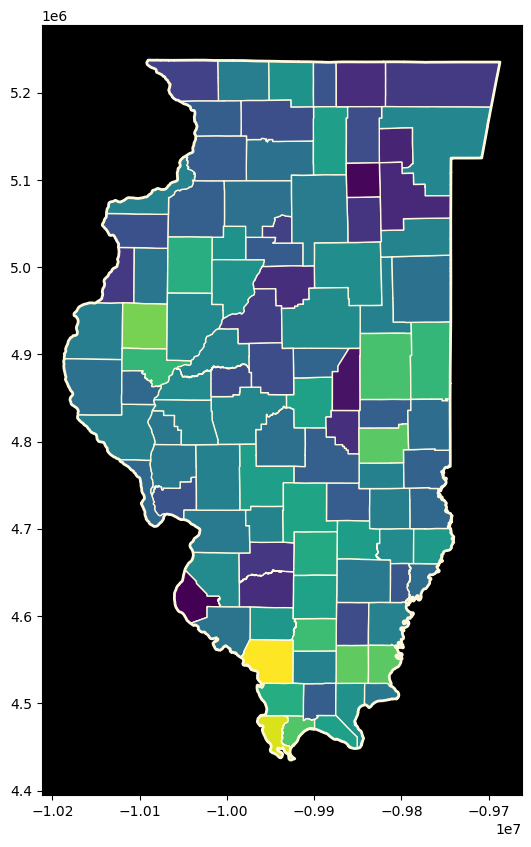

In [46]:
f, ax = plt.subplots(1,1,figsize=(10,10))
il.dropna(subset=['% In Poverty'], axis=0).plot('% In Poverty', ax=ax, cmap='viridis', edgecolor='cornsilk')
il_bounds.plot(edgecolor='cornsilk', color='none', ax=ax, linewidth=2)
ax.set_facecolor('k')

The counties in Illinois with the highest proportions of population in poverty in 2019 included Jackson, McDonough, and Alexander County among others, with the highest being about 26% of the total county population. My next step is to run the same analysis of percent change in this amount from 2009 to 2019. I switch back to the figure_factory choropleth because cenpy is unable to fetch the relevant data from 2009. 

In [57]:
df_ratio = censusdata.download('acs5', 2019, censusdata.censusgeo(
    [('state', '17'), ('county', '*')]), ['C17002_001E', 'C17002_002E', 'C17002_003E'])
df_ratio2 = censusdata.download('acs5', 2009, censusdata.censusgeo(
    [('state', '17'), ('county', '*')]), ['C17002_001E', 'C17002_002E', 'C17002_003E'])
column_names = ['Total', '<0.50', '0.50to0.99']
df_ratio.columns = column_names
df_ratio2.columns = column_names
FIPS_codes = []
county_names = []
for index in df_ratio.index.tolist():
    FIPScode = index.geo[0][1] + index.geo[1][1]
    FIPS_codes.append(FIPScode)
    countyname = index.name.split(',')[0]
    county_names.append(countyname)
df_ratio.index = FIPS_codes
df_ratio['County'] = county_names
df_ratio2.index = FIPS_codes
df_ratio2['County'] = county_names

df_ratio['%inPoverty'] = (df_ratio['<0.50'] + df_ratio['0.50to0.99']) / df_ratio['Total']
df_ratio2['%inPoverty'] = (df_ratio2['<0.50'] + df_ratio2['0.50to0.99']) / df_ratio2['Total']

df_ratio.sort_values('%inPoverty', ascending=False).head(4)

,Total,<0.50,0.50to0.99,County,%inPoverty
17077,53972,7411,6896,Jackson County,0.265082
17003,6143,686,867,Alexander County,0.252808
17109,27017,3323,2605,McDonough County,0.219417
17165,23435,2218,2718,Saline County,0.210625


In [61]:
df_ratio2[df_ratio2['County']=='Kendall County']

,Total,<0.50,0.50to0.99,County,%inPoverty
17093,5169821,356565,424452,Kendall County,0.151072


In [62]:
df4 = pd.concat([df_ratio['County'], df_ratio['%inPoverty'], df_ratio2['%inPoverty']], axis=1, keys=['County', '%Poverty2019', '%Poverty2009'])
df4['%_Change'] = -(df4['%Poverty2019'] - df4['%Poverty2009']) / df4['%Poverty2009']
df4.sort_values('%_Change').head(4)

,County,%Poverty2019,%Poverty2009,%_Change
17059,Gallatin County,0.208499,0.053159,-2.922157
17099,LaSalle County,0.133545,0.034607,-2.858913
17135,Montgomery County,0.165809,0.055715,-1.976034
17003,Alexander County,0.252808,0.088285,-1.863558


In [65]:
fig5 = ff.create_choropleth(fips=df4.index, scope=['Illinois'], values=df4['%_Change'],
                           title='% Change in Poverty Relative to County Population', legend_title='% Decrease in Poverty')
fig5.layout.template = None
fig5.show()

Alexander County is interesting, because it contains the highest relative population of African Americans and American Indians in Illinois. It also has the highest poverty rate in the state. Furthermore, it has an interesting history dating back to the Civil War and could be an interesting subject of further analysis regarding its demographics, politics and communities. More information could be found here: https://22rivers.com/2009/10/11/the-great-migration-of-cairo-illinois/ 

# Conclusion

This was an interesting project and a good introduction into the realm of census data/geospatial analysis. I'm excited to see where I can take this further in the future, and there are definitely ways for me to improve on analysis. For example, I may take the time to familiarize myself more with GeoPandas and matplotlib for making my own visualizations in the future. The different ways of making choropleths that I've explored in this project both leave things to be desired. Furthermore, a deeper analysis into the counties/tracts themselves can yield more valuable and impactful information, along with more clever manipulation of data to find connections. Additionally, the breadth and depth of census data is such that different search terms could have yielded more relevant/specific tables.